# Using Croissant 🥐, Hugging Face 🤗, and DataPipes for FLORES200

## Introduction

In this notebook, we'll show how Croissant can be used within the [PyTorch](https://pytorch.org/) framework to finetune a model using a [DataPipes](https://pytorch.org/data/main/torchdata.datapipes.iter.html) loader.
We'll be using the [FLORES-200](https://github.com/facebookresearch/flores/blob/main/flores200/README.md) dataset with a [BERT](https://arxiv.org/abs/1810.04805) model hosted on [Hugging Face transformers](https://huggingface.co/bert-base-multilingual-cased).
This notebook fine-tunes the BERT model to classify between the 200+ languages present in FLORES-200, also known as *language identification*.
For the loader, we utilize a minimal DataPipe adapter on top of `mlcroissant` to help facilitate dataloading.

First, let's start by installing some dependencies.

In [1]:
# Install some needed dependencies for the notebook
!apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
!pip install --quiet "git+https://github.com/${GITHUB_REPOSITORY:-mlcommons/croissant}.git@${GITHUB_HEAD_REF:-main}#subdirectory=python/mlcroissant&egg=mlcroissant[dev]"
!pip install --quiet "torch==2.2.1"
!pip install --quiet torchvision torchaudio torchdata transformers numpy graphviz

DEPRECATION: git+https://github.com/mlcommons/croissant.git@main#subdirectory=python/mlcroissant&egg=mlcroissant[dev] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
DEPRECATION: git+https://github.com/google/etils.git#egg=etils[epath] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
DEPRECATION: git+https://github.com/google/etils.git#egg=etils[epath] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617


In [2]:
import functools
import os
import time

import mlcroissant as mlc

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchdata
from transformers import BertModel
from transformers import BertTokenizer

Next, we need to provide the PyTorch adapter a Croissant file to read!
We pass the FLORES-200 Croissant file to the class, which we will subsequently use to generate a PyTorch DataPipe for loading data.
For convenience, we specify that certain fields should be automatically converted to their corresponding data type.
We do this because Croissant implementations can return encoded data (e.g., UTF-8 bytes) for certain fields, but applications may expect decoded data (e.g., text strings).

In [3]:
ta_factory = mlc.torch.LoaderFactory(jsonld="../../../datasets/1.0/flores-200/metadata.json")
specification = {
    "translation": mlc.torch.LoaderSpecificationDataType.INFER,
    "language": mlc.torch.LoaderSpecificationDataType.INFER,
}

Using the adapter factory, we create a DataPipe.
Importantly, we create one DataPipe per record set.
In this case, this translates to a training set and a test set.

In [4]:
train_data_pipe = ta_factory.as_datapipe(
    record_set="language_translations_train_data_with_metadata",
    specification=specification,
)
test_data_pipe = ta_factory.as_datapipe(
    record_set="language_translations_test_data_with_metadata",
    specification=specification,
)

Finally, we get a DataPipe, which we can use to manipulate data with traditional PyTorch tools!
We can observe that these DataPipes are shallow wrappers around the base data.

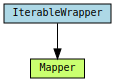

In [5]:
torchdata.datapipes.utils.to_graph(train_data_pipe)

## Setting Up The Data and Model

The first thing we have to do to use the data in a classification setting is map each language, which represents the target class, to an integer.
We'll quickly iterate the unique language descriptors to build this mapping.

In [6]:
classes_to_int = {
    y: i for i, y in enumerate(sorted(set(x["language"] for x in train_data_pipe)))
}
int_to_classes = {i: y for (y, i) in classes_to_int.items()}

Next, we need to set some hyperparameters that the rest of the code will use.
The pretrained model, the sequence dimensions, and performance-related settings are specified here.
Note we use an environment variable to override some defaults.

In [7]:
# Hyperparameters
MODEL_NAME = "bert-base-multilingual-cased"
MAX_LENGTH = int(os.environ.get("MAX_SEQUENCE_LENGTH", 10))
LEARNING_RATE = 1e-5
TRAIN_BATCH_SIZE = int(os.environ.get("TRAIN_BATCH_SIZE", 128))
TEST_BATCH_SIZE = int(os.environ.get("TEST_BATCH_SIZE", 128))
NUM_TRAIN_WORKERS = 0
NUM_TEST_WORKERS = 0
NUM_TRAIN_SAMPLES = 203388
NUM_TEST_SAMPLES = 206448
# 2 epochs is recommended for convergence
NUM_EPOCHS = float(os.environ.get("NUM_TRAIN_EPOCHS", 2.0))
# Testing can similarly be subsampled
FRACTION_TEST = float(os.environ.get("FRACTION_TEST", 1.0))

Next, we have to specify how the tokenization should be done.
We'll use the tokenizer that was used with the BERT model.
We'll also apply some padding and truncation to the tensors to simplify the implementation.

In [8]:
@functools.lru_cache(maxsize=1)
def get_tokenizer():
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
    return tokenizer

def unpack_row(x):
    tokenizer = get_tokenizer()
    tokenized = tokenizer(
        x["translation"],
        max_length=MAX_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors="np",
    )
    targets = classes_to_int[x["language"]]
    return {
        "input_ids": tokenized["input_ids"].reshape((-1,)),
        "attention_mask": tokenized["attention_mask"].reshape((-1,)),
        "token_type_ids": tokenized["token_type_ids"].reshape((-1,)),
        "targets": targets,
    }

Finally, we can create the train and test dataset.
Note that the test dataset does not need shuffling.
Otherwise, these two datasets are simply performing sharding and tokenization.

In [9]:
def get_train_dataset():
    train_dataset = train_data_pipe
    train_dataset = train_dataset.shuffle(buffer_size=10000)
    train_dataset = train_dataset.sharding_filter()
    train_dataset = train_dataset.map(unpack_row)
    return train_dataset


def get_test_dataset():
    test_dataset = test_data_pipe
    test_dataset = test_dataset.sharding_filter()
    test_dataset = test_dataset.map(unpack_row)
    return test_dataset

In [10]:
train_dataset = get_train_dataset()
test_dataset = get_test_dataset()

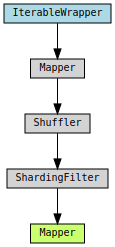

In [11]:
torchdata.datapipes.utils.to_graph(train_dataset)

Now, we can build our model.
We'll simply take the pretrained model and add a linear layer after pooling.
Note that BERT has a feature dimension of 768. 

In [12]:
class BERTClassifier(torch.nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.base = BertModel.from_pretrained(MODEL_NAME)
        self.fc = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, x = self.base(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False,
        )
        x = self.fc(x)
        return x

We're almost there!
Let's defined how to train and test the model.

In [13]:
def train(model, optimizer, dataloader, max_steps=None):
    if max_steps is None:
        max_steps = float("inf")
    elif max_steps <= 0:
        return

    model.train()
    criterion = torch.nn.CrossEntropyLoss().to(device)

    total_loss = 0
    total_samples = 0
    start_time = time.perf_counter()
    for iteration, data in enumerate(dataloader, 1):
        if iteration > max_steps:
            break
        input_ids = data["input_ids"].to(device, dtype=torch.long, non_blocking=True)
        attention_mask = data["attention_mask"].to(
            device, dtype=torch.long, non_blocking=True
        )
        token_type_ids = data["token_type_ids"].to(
            device, dtype=torch.long, non_blocking=True
        )
        targets = data["targets"].to(device, dtype=torch.long, non_blocking=True)

        outputs = model(input_ids, attention_mask, token_type_ids)

        loss = criterion(outputs, targets)
        total_loss += len(outputs) * loss.item()
        total_samples += len(outputs)
        if iteration % 100 == 0:
            with torch.no_grad():
                mean_loss = total_loss / total_samples
                elapsed_time = time.perf_counter() - start_time
                samples_per_second = total_samples / elapsed_time
                progress = total_samples / NUM_TRAIN_SAMPLES
                msg = (
                    f"[Train {progress:.1%}]: loss: {mean_loss:.2f} "
                    f"({samples_per_second:.2f} samples/sec)"
                )
                print(msg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = total_loss / total_samples
    return mean_loss


def test(model, dataloader, max_steps=None):
    if max_steps is None:
        max_steps = float("inf")
    elif max_steps <= 0:
        return

    model.eval()
    criterion = torch.nn.CrossEntropyLoss().to(device)

    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        start_time = time.perf_counter()
        for iteration, data in enumerate(dataloader, 1):
            if iteration > max_steps:
                break
            input_ids = data["input_ids"].to(
                device, dtype=torch.long, non_blocking=True
            )
            attention_mask = data["attention_mask"].to(
                device, dtype=torch.long, non_blocking=True
            )
            token_type_ids = data["token_type_ids"].to(
                device, dtype=torch.long, non_blocking=True
            )
            targets = data["targets"].to(device, dtype=torch.long, non_blocking=True)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = criterion(outputs, targets)
            total_loss += len(outputs) * loss.item()
            total_samples += len(outputs)
            preds = torch.argmax(outputs, axis=1)
            total_correct += torch.sum((preds == targets).float()).item()
            if iteration % 100 == 0:
                mean_loss = total_loss / total_samples
                accuracy = total_correct / total_samples
                elapsed_time = time.perf_counter() - start_time
                samples_per_second = total_samples / elapsed_time
                progress = total_samples / NUM_TEST_SAMPLES
                msg = (
                    f"[Test {progress:.1%}]: loss: {mean_loss:.2f}, "
                    f"accuracy: {accuracy:.1%} ({samples_per_second:.2f} samples/sec)"
                )
                print(msg)
        mean_loss = total_loss / total_samples
        accuracy = total_correct / total_samples
        return mean_loss, accuracy


def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

Now we are ready to train!

In [14]:
device = get_device()
model = BERTClassifier(len(classes_to_int))
model = model.to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_TRAIN_WORKERS,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    num_workers=NUM_TEST_WORKERS,
)

# We allow fractional epochs to speed up testing
# So 1.5 epochs would be 1 epoch plus half the next epoch
whole_epochs = int(NUM_EPOCHS)
remainder_train_steps = (NUM_EPOCHS - whole_epochs) * NUM_TRAIN_SAMPLES / TRAIN_BATCH_SIZE
max_test_steps = None
if FRACTION_TEST != 1.0:
    max_test_steps = FRACTION_TEST * NUM_TEST_SAMPLES / TEST_BATCH_SIZE

epoch = 0  # Define epoch in case the following skips
for epoch in range(whole_epochs):
    train_loss = train(model, optimizer, train_dataloader)
    test_loss, test_accuracy = test(model, test_dataloader, max_steps=max_test_steps)
    print(
        f"Epoch {epoch} train_loss: {train_loss:.2f}, "
        f"test_loss: {test_loss:.2f}, test_accuracy: {test_accuracy:.1%}"
    )
if remainder_train_steps:
    train_loss = train(model, optimizer, train_dataloader, max_steps=remainder_train_steps)
    test_loss, test_accuracy = test(model, test_dataloader, max_steps=max_test_steps)
    print(
        f"Epoch {epoch} train_loss: {train_loss:.2f}, "
        f"test_loss: {test_loss:.2f}, test_accuracy: {test_accuracy:.1%}"
    )

[Train 6.3%]: loss: 5.19 (223.96 samples/sec)
[Train 12.6%]: loss: 4.87 (237.11 samples/sec)
[Train 18.9%]: loss: 4.57 (243.10 samples/sec)
[Train 25.2%]: loss: 4.31 (246.82 samples/sec)
[Train 31.5%]: loss: 4.09 (249.75 samples/sec)
[Train 37.8%]: loss: 3.89 (251.21 samples/sec)
[Train 44.1%]: loss: 3.71 (252.13 samples/sec)
[Train 50.3%]: loss: 3.54 (251.95 samples/sec)
[Train 56.6%]: loss: 3.40 (252.14 samples/sec)
[Train 62.9%]: loss: 3.26 (252.15 samples/sec)
[Train 69.2%]: loss: 3.14 (252.27 samples/sec)
[Train 75.5%]: loss: 3.04 (252.25 samples/sec)
[Train 81.8%]: loss: 2.94 (252.22 samples/sec)
[Train 88.1%]: loss: 2.84 (252.15 samples/sec)
[Train 94.4%]: loss: 2.76 (252.08 samples/sec)
[Test 6.2%]: loss: 1.49, accuracy: 62.6% (593.88 samples/sec)
[Test 12.4%]: loss: 1.49, accuracy: 62.5% (702.67 samples/sec)
[Test 18.6%]: loss: 1.46, accuracy: 62.9% (747.07 samples/sec)
[Test 24.8%]: loss: 1.48, accuracy: 62.5% (772.61 samples/sec)
[Test 31.0%]: loss: 1.47, accuracy: 62.5% (79

## Trying It Out

Now that we have a model, we can see how it performs on some (perhaps) realistic examples 😁.
Below, we pick a few translations of "Croissants are tasty!" to see how the model does.

In [16]:
sample_cases = [
    "Croissants are tasty!",
    "¡Los croissants son deliciosos!",
    "Les croissants sont savoureux!",
    "羊角面包很好吃!",
    "הקרואסונים טעימים!",
    "Kruvasanlar juda mazali!",
]

In [17]:
tokenizer = get_tokenizer()
for case in sample_cases:
    toks = tokenizer(case, return_tensors="pt")
    logits = model(
        toks["input_ids"].to(device),
        toks["attention_mask"].to(device),
        toks["token_type_ids"].to(device),
    )
    y_pred = torch.argmax(logits, axis=1).item()
    pred_lang = int_to_classes[y_pred]
    print(f"'{case}' → '{pred_lang}'")

'Croissants are tasty!' → 'eng_Latn'
'¡Los croissants son deliciosos!' → 'spa_Latn'
'Les croissants sont savoureux!' → 'fra_Latn'
'羊角面包很好吃!' → 'zho_Hant'
'הקרואסונים טעימים!' → 'heb_Hebr'
'Kruvasanlar juda mazali!' → 'uzn_Latn'
